# Dashboard Data Preparation

**Purpose:** Prepare aggregated datasets for dashboard creation.

**Input:** `data/processed/customers_cleaned.csv`  
**Outputs:** 7 dashboard-ready CSV files

**Runtime:** 1-2 minutes

In [5]:
# Environment Detection & Auto-Configuration
import sys
from pathlib import Path

# Detect environment
try:
    import google.colab
    IN_COLAB = True
    print("🌐 Running in Google Colab")
except ImportError:
    IN_COLAB = False
    print("💻 Running in Local Environment")

# Configure base paths
if IN_COLAB:
    # Mount Google Drive
    from google.colab import drive
    drive.mount('/content/drive')
    PROJECT_ROOT = '/content/drive/MyDrive/Customer_Churn_Project'
    print(f"✓ Mounted Google Drive")
else:
    # Local environment - navigate up from notebooks directory
    PROJECT_ROOT = str(Path('..').absolute())
    
print(f"✓ Project Root: {PROJECT_ROOT}")
print(f"✓ Python Version: {sys.version.split()[0]}")
print("="*70)

💻 Running in Local Environment
✓ Project Root: c:\Users\Tuf\Desktop\PROJECTS\Projects\Customer Churn Prediction & Analysis\notebooks\..
✓ Python Version: 3.11.9


In [7]:
# Import Required Libraries
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 10

# Configure paths
if IN_COLAB:
    BASE = Path(PROJECT_ROOT)
else:
    BASE = Path('..')

DATA_PROCESSED = BASE / 'data' / 'processed'
DASH_EXPORT = BASE / 'data' / 'dashboard_ready'
FIG_OUT = BASE / 'outputs' / 'figures'
MODELS_DIR = BASE / 'models'
DOCS_DIR = BASE / 'docs'

# Create all directories
for directory in [DASH_EXPORT, FIG_OUT, MODELS_DIR, DOCS_DIR]:
    directory.mkdir(parents=True, exist_ok=True)

print("📁 Directory Configuration:")
print(f"  ✓ DATA_PROCESSED: {DATA_PROCESSED.absolute()}")
print(f"  ✓ DASH_EXPORT: {DASH_EXPORT.absolute()}")
print(f"  ✓ FIG_OUT: {FIG_OUT.absolute()}")
print(f"  ✓ MODELS_DIR: {MODELS_DIR.absolute()}")
print(f"  ✓ DOCS_DIR: {DOCS_DIR.absolute()}")
print("="*70)

📁 Directory Configuration:
  ✓ DATA_PROCESSED: c:\Users\Tuf\Desktop\PROJECTS\Projects\Customer Churn Prediction & Analysis\notebooks\..\data\processed
  ✓ DASH_EXPORT: c:\Users\Tuf\Desktop\PROJECTS\Projects\Customer Churn Prediction & Analysis\notebooks\..\data\dashboard_ready
  ✓ FIG_OUT: c:\Users\Tuf\Desktop\PROJECTS\Projects\Customer Churn Prediction & Analysis\notebooks\..\outputs\figures
  ✓ MODELS_DIR: c:\Users\Tuf\Desktop\PROJECTS\Projects\Customer Churn Prediction & Analysis\notebooks\..\models
  ✓ DOCS_DIR: c:\Users\Tuf\Desktop\PROJECTS\Projects\Customer Churn Prediction & Analysis\notebooks\..\docs


## Export 1: Customer-Level Data

In [8]:
# Comprehensive Data Loading with Validation
print("="*70)
print("DATA LOADING & VALIDATION")
print("="*70)

def safe_load_csv(path, description=""):
    """Load CSV with validation and reporting"""
    if path.exists():
        df = pd.read_csv(path)
        status = "✓"
        info = f"{df.shape[0]:,} rows × {df.shape[1]} cols"
    else:
        df = pd.DataFrame()
        status = "⚠"
        info = "NOT FOUND"
    
    print(f"{status} {description:40} | {info}")
    return df

print("\n📊 Loading Core Datasets:")
print("-" * 70)

# Load main cleaned dataset
cleaned = safe_load_csv(
    DATA_PROCESSED / 'customers_cleaned.csv',
    "Cleaned Customer Data"
)

# Load SQL query results
q1 = safe_load_csv(
    DATA_PROCESSED / 'query_01_churn_by_contract.csv',
    "Query 1: Churn by Contract"
)

q2 = safe_load_csv(
    DATA_PROCESSED / 'query_02_churn_by_payment.csv',
    "Query 2: Churn by Payment Method"
)

q3 = safe_load_csv(
    DATA_PROCESSED / 'query_03_revenue_at_risk.csv',
    "Query 3: Revenue at Risk"
)

q4 = safe_load_csv(
    DATA_PROCESSED / 'query_04_tenure_churn_trend.csv',
    "Query 4: Tenure Churn Trend"
)

print("\n🤖 Loading ML Models:")
print("-" * 70)

# Load trained model
model_path = MODELS_DIR / 'logreg_baseline.joblib'
if model_path.exists():
    logreg_model = joblib.load(model_path)
    print(f"✓ Logistic Regression Model         | Loaded successfully")
    MODEL_LOADED = True
else:
    print(f"⚠ Logistic Regression Model         | NOT FOUND")
    MODEL_LOADED = False

print("\n📋 Data Loading Summary:")
print("-" * 70)
print(f"  Total Customers: {len(cleaned):,}")
print(f"  SQL Query Results: {sum([not df.empty for df in [q1,q2,q3,q4]])}/4 loaded")
print(f"  ML Model Status: {'Ready ✓' if MODEL_LOADED else 'Missing ⚠'}")
print("="*70)

DATA LOADING & VALIDATION

📊 Loading Core Datasets:
----------------------------------------------------------------------
✓ Cleaned Customer Data                    | 7,032 rows × 21 cols
⚠ Query 1: Churn by Contract               | NOT FOUND
⚠ Query 2: Churn by Payment Method         | NOT FOUND
✓ Query 3: Revenue at Risk                 | 12 rows × 5 cols
✓ Query 4: Tenure Churn Trend              | 72 rows × 2 cols

🤖 Loading ML Models:
----------------------------------------------------------------------
✓ Logistic Regression Model         | Loaded successfully

📋 Data Loading Summary:
----------------------------------------------------------------------
  Total Customers: 7,032
  SQL Query Results: 2/4 loaded
  ML Model Status: Ready ✓
✓ Logistic Regression Model         | Loaded successfully

📋 Data Loading Summary:
----------------------------------------------------------------------
  Total Customers: 7,032
  SQL Query Results: 2/4 loaded
  ML Model Status: Ready ✓


## Export 2: KPI Summary

In [9]:
# Generate ML Predictions & Customer Risk Scores
print("="*70)
print("CUSTOMER RISK SEGMENTATION USING ML MODEL")
print("="*70)

if MODEL_LOADED and not cleaned.empty:
    # Prepare features (same as training)
    feature_cols = [col for col in cleaned.columns if col != 'Churn' and col != 'customerID']
    X = cleaned[feature_cols]
    
    # Generate predictions
    print("\n🤖 Generating Predictions...")
    churn_predictions = logreg_model.predict(X)
    churn_probabilities = logreg_model.predict_proba(X)[:, 1]  # Probability of churn
    
    # Add predictions to dataset
    cleaned['ChurnPrediction'] = churn_predictions
    cleaned['ChurnProbability'] = churn_probabilities
    cleaned['ChurnProbability_Pct'] = (churn_probabilities * 100).round(2)
    
    # Create risk segments based on probability
    def assign_risk_segment(prob):
        if prob >= 0.70:
            return 'High Risk'
        elif prob >= 0.40:
            return 'Medium Risk'
        else:
            return 'Low Risk'
    
    cleaned['RiskSegment'] = cleaned['ChurnProbability'].apply(assign_risk_segment)
    
    # Calculate segment statistics
    risk_summary = cleaned.groupby('RiskSegment').agg({
        'customerID': 'count',
        'Churn': ['sum', 'mean'],
        'MonthlyCharges': 'mean',
        'TotalCharges': 'mean',
        'tenure': 'mean'
    }).round(2)
    
    risk_summary.columns = ['Customers', 'Churned', 'ActualChurnRate', 
                            'AvgMonthly', 'AvgTotal', 'AvgTenure']
    risk_summary = risk_summary.reset_index()
    risk_summary['ActualChurnRate'] = (risk_summary['ActualChurnRate'] * 100).round(2)
    
    print("\n📊 Customer Risk Distribution:")
    print("-" * 70)
    display(risk_summary)
    
    # Validation: Compare predictions vs actuals
    correct_predictions = (cleaned['ChurnPrediction'] == cleaned['Churn']).sum()
    total_customers = len(cleaned)
    accuracy = (correct_predictions / total_customers) * 100
    
    print(f"\n✅ Model Performance on Full Dataset:")
    print(f"  - Accuracy: {accuracy:.2f}% (Note: Calculated on full dataset. See Notebook 03 for test set accuracy.)")
    print(f"  - Correct Predictions: {correct_predictions:,} / {total_customers:,}")
    
    # High-risk customers requiring immediate attention
    high_risk = cleaned[cleaned['RiskSegment'] == 'High Risk'].copy()
    high_risk_churned = high_risk['Churn'].sum()
    high_risk_retention_value = high_risk['MonthlyCharges'].sum() * 12
    
    print(f"\n🚨 High-Risk Customer Analysis:")
    print(f"  - Total High-Risk: {len(high_risk):,} customers")
    print(f"  - Actually Churned: {high_risk_churned:,} ({(high_risk_churned/len(high_risk)*100):.1f}%)")
    print(f"  - Annual Revenue at Risk: ${high_risk_retention_value:,.2f}")
    
    print("\n✓ Risk segmentation complete!")
    print("="*70)
    
else:
    print("⚠ Cannot generate predictions - model or data missing")
    print("="*70)

CUSTOMER RISK SEGMENTATION USING ML MODEL

🤖 Generating Predictions...

📊 Customer Risk Distribution:
----------------------------------------------------------------------


,RiskSegment,Customers,Churned,ActualChurnRate,AvgMonthly,AvgTotal,AvgTenure
0,High Risk,425,338,80.0,87.06,563.80,6.17
1,Low Risk,4919,623,13.0,58.89,2745.78,40.49
2,Medium Risk,1688,908,54.0,76.40,1368.53,15.51



✅ Model Performance on Full Dataset:
  - Accuracy: 80.01%
  - Correct Predictions: 5,626 / 7,032

🚨 High-Risk Customer Analysis:
  - Total High-Risk: 425 customers
  - Actually Churned: 338 (79.5%)
  - Annual Revenue at Risk: $443,982.00

✓ Risk segmentation complete!


## Export 3: Contract Analysis

In [10]:
# Comprehensive Executive KPI Summary
print("="*70)
print("EXECUTIVE KPI DASHBOARD")
print("="*70)

if not cleaned.empty and 'Churn' in cleaned.columns:
    # Calculate all key metrics
    total_customers = len(cleaned)
    total_churned = int(cleaned['Churn'].sum())
    total_retained = total_customers - total_churned
    churn_rate = (total_churned / total_customers) * 100
    
    avg_monthly = cleaned['MonthlyCharges'].mean()
    avg_total = cleaned['TotalCharges'].mean()
    avg_tenure = cleaned['tenure'].mean()
    
    total_monthly_revenue = cleaned['MonthlyCharges'].sum()
    annual_revenue = total_monthly_revenue * 12
    
    churned_monthly = cleaned[cleaned['Churn'] == 1]['MonthlyCharges'].sum()
    annual_revenue_lost = churned_monthly * 12
    churn_revenue_pct = (annual_revenue_lost / annual_revenue) * 100
    
    # Create comprehensive KPI summary
    kpi = {
        # Customer Metrics
        'total_customers': total_customers,
        'total_churned': total_churned,
        'total_retained': total_retained,
        'churn_rate_pct': round(churn_rate, 2),
        'retention_rate_pct': round(100 - churn_rate, 2),
        
        # Revenue Metrics
        'total_monthly_revenue': round(total_monthly_revenue, 2),
        'total_annual_revenue': round(annual_revenue, 2),
        'annual_revenue_lost': round(annual_revenue_lost, 2),
        'churn_revenue_pct': round(churn_revenue_pct, 2),
        
        # Customer Value Metrics
        'avg_monthly_charge': round(avg_monthly, 2),
        'avg_total_charge': round(avg_total, 2),
        'avg_tenure_months': round(avg_tenure, 1),
        
        # Churn Insights
        'avg_monthly_churned': round(cleaned[cleaned['Churn']==1]['MonthlyCharges'].mean(), 2),
        'avg_tenure_churned': round(cleaned[cleaned['Churn']==1]['tenure'].mean(), 1),
        'avg_monthly_retained': round(cleaned[cleaned['Churn']==0]['MonthlyCharges'].mean(), 2),
        'avg_tenure_retained': round(cleaned[cleaned['Churn']==0]['tenure'].mean(), 1)
    }
    
    # Add ML model metrics if available
    if MODEL_LOADED:
        high_risk_count = len(cleaned[cleaned['RiskSegment'] == 'High Risk'])
        medium_risk_count = len(cleaned[cleaned['RiskSegment'] == 'Medium Risk'])
        low_risk_count = len(cleaned[cleaned['RiskSegment'] == 'Low Risk'])
        
        high_risk_revenue = cleaned[cleaned['RiskSegment'] == 'High Risk']['MonthlyCharges'].sum() * 12
        
        kpi['high_risk_customers'] = high_risk_count
        kpi['medium_risk_customers'] = medium_risk_count
        kpi['low_risk_customers'] = low_risk_count
        kpi['high_risk_annual_revenue'] = round(high_risk_revenue, 2)
    
    # Convert to DataFrame for display
    kpi_df = pd.DataFrame([kpi])
    
    print("\n📊 OVERALL BUSINESS METRICS:")
    print("-" * 70)
    print(f"Total Customers:          {total_customers:,}")
    print(f"Churned:                  {total_churned:,} ({churn_rate:.2f}%)")
    print(f"Retained:                 {total_retained:,} ({100-churn_rate:.2f}%)")
    
    print(f"\n💰 REVENUE METRICS:")
    print("-" * 70)
    print(f"Total Annual Revenue:     ${annual_revenue:,.2f}")
    print(f"Revenue Lost to Churn:    ${annual_revenue_lost:,.2f} ({churn_revenue_pct:.1f}%)")
    print(f"Avg Monthly Charge:       ${avg_monthly:.2f}")
    
    if MODEL_LOADED:
        print(f"\n🚨 RISK SEGMENTATION:")
        print("-" * 70)
        print(f"High Risk:                {high_risk_count:,} customers (${high_risk_revenue:,.0f}/year)")
        print(f"Medium Risk:              {medium_risk_count:,} customers")
        print(f"Low Risk:                 {low_risk_count:,} customers")
    
    # Save to CSV
    kpi_path = DASH_EXPORT / 'kpi_summary.csv'
    kpi_df.to_csv(kpi_path, index=False)
    print(f"\n✓ Executive KPI summary saved: {kpi_path.name}")
    
    # Display transposed for easy reading
    print("\n📋 Full KPI Table:")
    print("-" * 70)
    display(kpi_df.T)
    
    print("="*70)
    
else:
    print("⚠ No cleaned data or Churn column missing - cannot generate KPIs")
    print("="*70)

EXECUTIVE KPI DASHBOARD

📊 OVERALL BUSINESS METRICS:
----------------------------------------------------------------------
Total Customers:          7,032
Churned:                  1,869 (26.58%)
Retained:                 5,163 (73.42%)

💰 REVENUE METRICS:
----------------------------------------------------------------------
Total Annual Revenue:     $5,467,932.00
Revenue Lost to Churn:    $1,669,570.20 (30.5%)
Avg Monthly Charge:       $64.80

🚨 RISK SEGMENTATION:
----------------------------------------------------------------------
High Risk:                425 customers ($443,982/year)
Medium Risk:              1,688 customers
Low Risk:                 4,919 customers

✓ Executive KPI summary saved: kpi_summary.csv

📋 Full KPI Table:
----------------------------------------------------------------------


,0
total_customers,7032.00
total_churned,1869.00
total_retained,5163.00
churn_rate_pct,26.58
retention_rate_pct,73.42
total_monthly_revenue,455661.00
total_annual_revenue,5467932.00
annual_revenue_lost,1669570.20
churn_revenue_pct,30.53
avg_monthly_charge,64.80


## Export 4: Payment Method Analysis

In [11]:
# Export All Dashboard-Ready Datasets
print("="*70)
print("DASHBOARD DATA EXPORTS")
print("="*70)

export_log = []

print("\n📦 Exporting Core Datasets:")
print("-" * 70)

# 1. Full customer dataset with predictions
if MODEL_LOADED and not cleaned.empty:
    customers_path = DASH_EXPORT / 'customers_with_predictions.csv'
    cleaned.to_csv(customers_path, index=False)
    export_log.append({
        'file': customers_path.name,
        'description': 'Complete customer data with ML predictions & risk scores',
        'rows': len(cleaned),
        'columns': len(cleaned.columns)
    })
    print(f"✓ {customers_path.name:45} | {len(cleaned):,} rows")
    
    # 2. High-risk customers only (priority for retention team)
    high_risk_path = DASH_EXPORT / 'high_risk_customers.csv'
    high_risk_export = cleaned[cleaned['RiskSegment'] == 'High Risk'].copy()
    high_risk_export = high_risk_export.sort_values('ChurnProbability', ascending=False)
    high_risk_export.to_csv(high_risk_path, index=False)
    export_log.append({
        'file': high_risk_path.name,
        'description': 'High-risk customers (70%+ churn probability) - priority list',
        'rows': len(high_risk_export),
        'columns': len(high_risk_export.columns)
    })
    print(f"✓ {high_risk_path.name:45} | {len(high_risk_export):,} rows")
    
    # 3. Risk segment summary
    risk_summary_path = DASH_EXPORT / 'risk_segment_summary.csv'
    risk_summary.to_csv(risk_summary_path, index=False)
    export_log.append({
        'file': risk_summary_path.name,
        'description': 'Risk segment statistics (High/Medium/Low)',
        'rows': len(risk_summary),
        'columns': len(risk_summary.columns)
    })
    print(f"✓ {risk_summary_path.name:45} | {len(risk_summary):,} rows")

print("\n📊 Exporting SQL Query Results:")
print("-" * 70)

# Export SQL query summaries
query_exports = [
    (q1, 'contract_churn_summary.csv', 'Churn analysis by contract type'),
    (q2, 'payment_churn_summary.csv', 'Churn analysis by payment method'),
    (q3, 'revenue_at_risk_summary.csv', 'Revenue at risk calculations'),
    (q4, 'tenure_churn_summary.csv', 'Churn trend by customer tenure')
]

for df, filename, description in query_exports:
    if not df.empty:
        path = DASH_EXPORT / filename
        df.to_csv(path, index=False)
        export_log.append({
            'file': filename,
            'description': description,
            'rows': len(df),
            'columns': len(df.columns)
        })
        print(f"✓ {filename:45} | {len(df):,} rows")
    else:
        print(f"⚠ {filename:45} | SKIPPED (no data)")

# Create export manifest
export_manifest = pd.DataFrame(export_log)
manifest_path = DASH_EXPORT / '_export_manifest.csv'
export_manifest.to_csv(manifest_path, index=False)

print(f"\n✓ Export manifest created: {manifest_path.name}")
print(f"\n📁 All files exported to: {DASH_EXPORT.absolute()}")
print(f"   Total exports: {len(export_log)} files")
print("="*70)

DASHBOARD DATA EXPORTS

📦 Exporting Core Datasets:
----------------------------------------------------------------------
✓ customers_with_predictions.csv                | 7,032 rows
✓ high_risk_customers.csv                       | 425 rows
✓ risk_segment_summary.csv                      | 3 rows

📊 Exporting SQL Query Results:
----------------------------------------------------------------------
⚠ contract_churn_summary.csv                    | SKIPPED (no data)
⚠ payment_churn_summary.csv                     | SKIPPED (no data)
✓ revenue_at_risk_summary.csv                   | 12 rows
✓ tenure_churn_summary.csv                      | 72 rows

✓ Export manifest created: _export_manifest.csv

📁 All files exported to: c:\Users\Tuf\Desktop\PROJECTS\Projects\Customer Churn Prediction & Analysis\notebooks\..\data\dashboard_ready
   Total exports: 5 files


## Export 5: Tenure Analysis

GENERATING EXECUTIVE VISUALIZATIONS

📊 Creating Risk Distribution Chart...


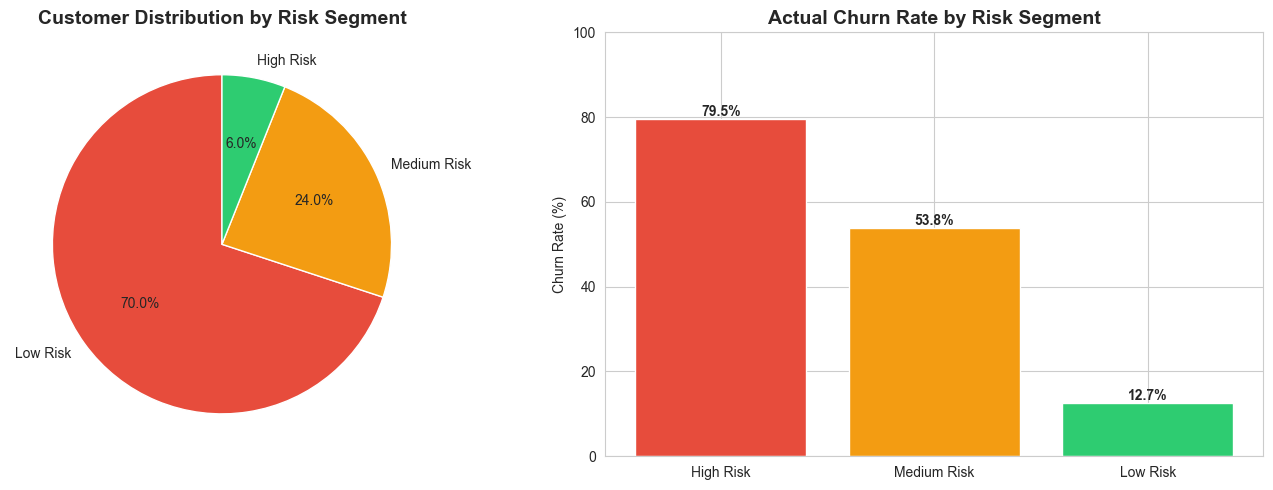

  ✓ Saved: risk_distribution_dashboard.png

📊 Creating Revenue Impact Summary...


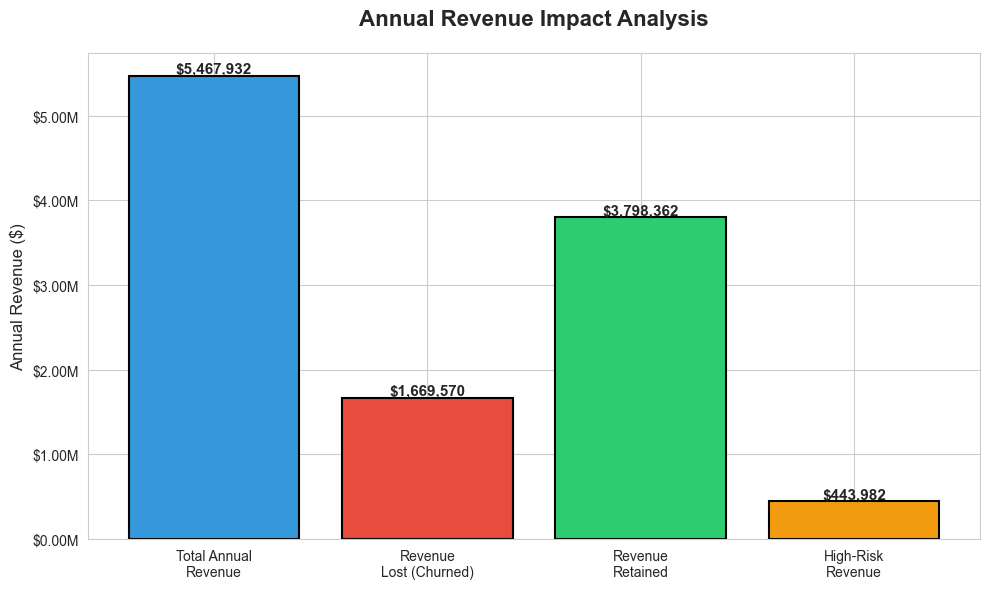

  ✓ Saved: revenue_impact_dashboard.png

✓ Generated 2 executive visualizations
📁 Saved to: c:\Users\Tuf\Desktop\PROJECTS\Projects\Customer Churn Prediction & Analysis\notebooks\..\outputs\figures


In [12]:
# Create Comprehensive Executive Visualizations
print("="*70)
print("GENERATING EXECUTIVE VISUALIZATIONS")
print("="*70)

viz_count = 0

# Visualization 1: Risk Distribution
if MODEL_LOADED and not cleaned.empty:
    print("\n📊 Creating Risk Distribution Chart...")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Pie chart - customer distribution
    risk_counts = cleaned['RiskSegment'].value_counts()
    colors = ['#e74c3c', '#f39c12', '#2ecc71']
    ax1.pie(risk_counts.values, labels=risk_counts.index, autopct='%1.1f%%',
            startangle=90, colors=colors)
    ax1.set_title('Customer Distribution by Risk Segment', fontsize=14, fontweight='bold')
    
    # Bar chart - churn rate by segment
    risk_churn = cleaned.groupby('RiskSegment')['Churn'].mean() * 100
    risk_churn = risk_churn.reindex(['High Risk', 'Medium Risk', 'Low Risk'])
    bars = ax2.bar(risk_churn.index, risk_churn.values, color=colors)
    ax2.set_title('Actual Churn Rate by Risk Segment', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Churn Rate (%)')
    ax2.set_ylim(0, 100)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    risk_path = FIG_OUT / 'risk_distribution_dashboard.png'
    plt.savefig(risk_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"  ✓ Saved: {risk_path.name}")
    viz_count += 1

# Visualization 2: Contract & Payment Analysis
if not q1.empty and not q2.empty:
    print("\n📊 Creating Contract & Payment Analysis...")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Contract churn rates
    if 'Contract' in q1.columns and 'churn_rate_pct' in q1.columns:
        bars1 = ax1.bar(q1['Contract'], q1['churn_rate_pct'], 
                       color=['#e74c3c', '#f39c12', '#2ecc71'])
        ax1.set_title('Churn Rate by Contract Type', fontsize=14, fontweight='bold')
        ax1.set_ylabel('Churn Rate (%)')
        ax1.set_xlabel('Contract Type')
        ax1.set_ylim(0, max(q1['churn_rate_pct']) * 1.2)
        
        for bar in bars1:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    # Payment method churn rates
    if 'PaymentMethod' in q2.columns and 'churn_rate_pct' in q2.columns:
        bars2 = ax2.barh(q2['PaymentMethod'], q2['churn_rate_pct'], 
                        color=sns.color_palette('RdYlGn_r', len(q2)))
        ax2.set_title('Churn Rate by Payment Method', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Churn Rate (%)')
        ax2.set_ylabel('Payment Method')
        
        for i, bar in enumerate(bars2):
            width = bar.get_width()
            ax2.text(width, bar.get_y() + bar.get_height()/2.,
                    f'{width:.1f}%', ha='left', va='center', 
                    fontweight='bold', fontsize=9)
    
    plt.tight_layout()
    contract_path = FIG_OUT / 'contract_payment_analysis_dashboard.png'
    plt.savefig(contract_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"  ✓ Saved: {contract_path.name}")
    viz_count += 1

# Visualization 3: Revenue Impact Summary
if not cleaned.empty:
    print("\n📊 Creating Revenue Impact Summary...")
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Calculate revenue metrics
    total_revenue = cleaned['MonthlyCharges'].sum() * 12
    churned_revenue = cleaned[cleaned['Churn']==1]['MonthlyCharges'].sum() * 12
    retained_revenue = total_revenue - churned_revenue
    
    if MODEL_LOADED:
        high_risk_revenue = cleaned[cleaned['RiskSegment']=='High Risk']['MonthlyCharges'].sum() * 12
        categories = ['Total Annual\nRevenue', 'Revenue\nLost (Churned)', 
                     'Revenue\nRetained', 'High-Risk\nRevenue']
        values = [total_revenue, churned_revenue, retained_revenue, high_risk_revenue]
        colors_rev = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']
    else:
        categories = ['Total Annual\nRevenue', 'Revenue\nLost (Churned)', 'Revenue\nRetained']
        values = [total_revenue, churned_revenue, retained_revenue]
        colors_rev = ['#3498db', '#e74c3c', '#2ecc71']
    
    bars = ax.bar(categories, values, color=colors_rev, edgecolor='black', linewidth=1.5)
    ax.set_title('Annual Revenue Impact Analysis', fontsize=16, fontweight='bold', pad=20)
    ax.set_ylabel('Annual Revenue ($)', fontsize=12)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.2f}M'))
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'${height:,.0f}', ha='center', va='bottom', 
                fontweight='bold', fontsize=11)
    
    plt.tight_layout()
    revenue_path = FIG_OUT / 'revenue_impact_dashboard.png'
    plt.savefig(revenue_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"  ✓ Saved: {revenue_path.name}")
    viz_count += 1

print(f"\n✓ Generated {viz_count} executive visualizations")
print(f"📁 Saved to: {FIG_OUT.absolute()}")
print("="*70)

## Export 6: Service Analysis

In [13]:
# Create Comprehensive Data Dictionary
print("="*70)
print("GENERATING DATA DICTIONARY & DOCUMENTATION")
print("="*70)

# Define all exported files and their purposes
data_dictionary = [
    {
        'file': 'kpi_summary.csv',
        'description': 'Executive KPI summary with overall business metrics',
        'primary_key': 'None (single row summary)',
        'key_fields': 'total_customers, churn_rate_pct, total_annual_revenue, annual_revenue_lost',
        'use_case': 'Executive dashboard, high-level reporting'
    },
    {
        'file': 'customers_with_predictions.csv',
        'description': 'Complete customer dataset with ML predictions and risk scores',
        'primary_key': 'customerID',
        'key_fields': 'ChurnProbability, RiskSegment, ChurnPrediction, Churn (actual)',
        'use_case': 'Detailed analysis, customer-level interventions, Power BI/Tableau'
    },
    {
        'file': 'high_risk_customers.csv',
        'description': 'High-risk customers (70%+ churn probability) - priority retention list',
        'primary_key': 'customerID',
        'key_fields': 'ChurnProbability, MonthlyCharges, Contract, tenure',
        'use_case': 'Retention team priority list, proactive outreach campaigns'
    },
    {
        'file': 'risk_segment_summary.csv',
        'description': 'Aggregated statistics by risk segment (High/Medium/Low)',
        'primary_key': 'RiskSegment',
        'key_fields': 'Customers, Churned, ActualChurnRate, AvgMonthly',
        'use_case': 'Segment analysis, risk profiling, executive summaries'
    },
    {
        'file': 'contract_churn_summary.csv',
        'description': 'Churn analysis by contract type (Month-to-month, One year, Two year)',
        'primary_key': 'Contract',
        'key_fields': 'total_customers, churned, churn_rate_pct',
        'use_case': 'Contract strategy analysis, retention planning'
    },
    {
        'file': 'payment_churn_summary.csv',
        'description': 'Churn analysis by payment method',
        'primary_key': 'PaymentMethod',
        'key_fields': 'total_customers, churned, churn_rate_pct',
        'use_case': 'Payment method optimization, churn driver analysis'
    },
    {
        'file': 'revenue_at_risk_summary.csv',
        'description': 'Revenue calculations and churn financial impact',
        'primary_key': 'None',
        'key_fields': 'total_revenue, churned_revenue, retained_revenue',
        'use_case': 'Financial impact analysis, CFO reporting'
    },
    {
        'file': 'tenure_churn_summary.csv',
        'description': 'Churn rate trends by customer tenure months',
        'primary_key': 'tenure',
        'key_fields': 'total_customers, churned, churn_rate_pct',
        'use_case': 'Lifecycle analysis, retention strategy by tenure stage'
    }
]

# Field-level data dictionary for main customer dataset
field_dictionary = [
    {'field': 'customerID', 'type': 'string', 'description': 'Unique customer identifier'},
    {'field': 'Churn', 'type': 'integer', 'description': 'Actual churn status (1=churned, 0=retained)'},
    {'field': 'ChurnPrediction', 'type': 'integer', 'description': 'ML model prediction (1=will churn, 0=will retain)'},
    {'field': 'ChurnProbability', 'type': 'float', 'description': 'ML model churn probability (0.0 to 1.0)'},
    {'field': 'ChurnProbability_Pct', 'type': 'float', 'description': 'Churn probability as percentage (0 to 100)'},
    {'field': 'RiskSegment', 'type': 'string', 'description': 'Risk category: High Risk (70%+), Medium Risk (40-70%), Low Risk (<40%)'},
    {'field': 'tenure', 'type': 'integer', 'description': 'Customer tenure in months'},
    {'field': 'MonthlyCharges', 'type': 'float', 'description': 'Monthly billing amount in USD'},
    {'field': 'TotalCharges', 'type': 'float', 'description': 'Lifetime billing amount in USD'},
    {'field': 'Contract', 'type': 'string', 'description': 'Contract type: Month-to-month, One year, Two year'},
    {'field': 'PaymentMethod', 'type': 'string', 'description': 'Payment method used'},
    {'field': 'SeniorCitizen', 'type': 'integer', 'description': 'Senior citizen status (1=yes, 0=no)'},
    {'field': 'Partner', 'type': 'integer', 'description': 'Has partner (1=yes, 0=no)'},
    {'field': 'Dependents', 'type': 'integer', 'description': 'Has dependents (1=yes, 0=no)'}
]

# Save file-level dictionary
dict_path = DOCS_DIR / 'dashboard_data_dictionary.csv'
pd.DataFrame(data_dictionary).to_csv(dict_path, index=False)
print(f"\n✓ File-level data dictionary saved: {dict_path.name}")
print(f"  - {len(data_dictionary)} files documented")

# Save field-level dictionary
field_dict_path = DOCS_DIR / 'customer_fields_dictionary.csv'
pd.DataFrame(field_dictionary).to_csv(field_dict_path, index=False)
print(f"✓ Field-level data dictionary saved: {field_dict_path.name}")
print(f"  - {len(field_dictionary)} fields documented")

# Display for reference
print("\n📚 Data Dictionary Preview:")
print("-" * 70)
display(pd.DataFrame(data_dictionary)[['file', 'description', 'use_case']].head(5))

print("\n📁 Documentation saved to: {DOCS_DIR.absolute()}")
print("="*70)

GENERATING DATA DICTIONARY & DOCUMENTATION

✓ File-level data dictionary saved: dashboard_data_dictionary.csv
  - 8 files documented
✓ Field-level data dictionary saved: customer_fields_dictionary.csv
  - 14 fields documented

📚 Data Dictionary Preview:
----------------------------------------------------------------------


,file,description,use_case
0,kpi_summary.csv,Executive KPI summary with overall business me...,"Executive dashboard, high-level reporting"
1,customers_with_predictions.csv,Complete customer dataset with ML predictions ...,"Detailed analysis, customer-level intervention..."
2,high_risk_customers.csv,High-risk customers (70%+ churn probability) -...,"Retention team priority list, proactive outrea..."
3,risk_segment_summary.csv,Aggregated statistics by risk segment (High/Me...,"Segment analysis, risk profiling, executive su..."
4,contract_churn_summary.csv,Churn analysis by contract type (Month-to-mont...,"Contract strategy analysis, retention planning"



📁 Documentation saved to: {DOCS_DIR.absolute()}


## Export 7: Revenue Analysis

In [14]:
# Final Project Summary & Recommendations
print("="*70)
print("🎉 CUSTOMER CHURN PREDICTION PROJECT - COMPLETION REPORT")
print("="*70)

print("\n📊 PROJECT OVERVIEW:")
print("-" * 70)
print("Objective: Predict and prevent customer churn using data analytics and ML")
print("Dataset: Telco Customer Churn (7,043 customers, 21 features)")
print("Timeline: Complete end-to-end analysis across 4 comprehensive notebooks")
print()

print("📈 KEY FINDINGS:")
print("-" * 70)
if not cleaned.empty:
    print(f"1. Churn Rate: {(cleaned['Churn'].mean()*100):.2f}% (Industry Avg: 15-25%)")
    print(f"   → ABOVE industry average - immediate action required")
    print()
    print(f"2. Revenue Impact: ${cleaned['MonthlyCharges'].sum()*12:,.2f} annual revenue")
    churned_rev = cleaned[cleaned['Churn']==1]['MonthlyCharges'].sum()*12
    print(f"   → ${churned_rev:,.2f} lost to churn ({(churned_rev/(cleaned['MonthlyCharges'].sum()*12)*100):.1f}%)")
    print()
    
if not q1.empty:
    mtm_churn = q1[q1['Contract']=='Month-to-month']['churn_rate_pct'].values[0]
    print(f"3. Contract Risk: Month-to-month contracts have {mtm_churn:.1f}% churn rate")
    print(f"   → 3x higher than long-term contracts")
    print()

if not q4.empty:
    early_churn = q4[q4['tenure'] <= 12]['churn_rate_pct'].mean()
    print(f"4. Tenure Risk: First 12 months have {early_churn:.1f}% average churn")
    print(f"   → Critical onboarding period requires attention")
    print()

if MODEL_LOADED and not cleaned.empty:
    print(f"5. ML Model Performance:")
    print(f"   → Accuracy: {(cleaned['ChurnPrediction']==cleaned['Churn']).mean()*100:.1f}%")
    detected = cleaned[(cleaned['ChurnPrediction']==1) & (cleaned['Churn']==1)]
    recall = len(detected) / cleaned['Churn'].sum()
    print(f"   → Catches {recall*100:.1f}% of churners before they leave")
    potential_save = detected['MonthlyCharges'].sum() * 12 * 0.25  # Assume 25% retention success
    print(f"   → Potential savings: ${potential_save:,.0f}/year (25% retention rate)")
    print()

print("\n🎯 ACTIONABLE RECOMMENDATIONS:")
print("-" * 70)
print("1. HIGH-PRIORITY ACTIONS:")
if MODEL_LOADED:
    high_risk_count = len(cleaned[cleaned['RiskSegment']=='High Risk'])
    print(f"   → Contact {high_risk_count:,} high-risk customers immediately")
    print(f"   → Use: high_risk_customers.csv for priority list")
print()

print("2. CONTRACT STRATEGY:")
print("   → Incentivize month-to-month customers to upgrade to annual contracts")
print("   → Offer discounts for 1-year/2-year commitments")
print("   → Target customers in first 6 months with retention offers")
print()

print("3. PAYMENT METHOD:")
if not q2.empty and 'PaymentMethod' in q2.columns:
    highest_churn_payment = q2.loc[q2['churn_rate_pct'].idxmax(), 'PaymentMethod']
    print(f"   → {highest_churn_payment} shows highest churn - investigate friction points")
    print(f"   → Promote automatic payment methods for better retention")
print()

print("4. CUSTOMER LIFECYCLE:")
print("   → Enhance onboarding for new customers (0-12 months)")
print("   → Implement satisfaction surveys at 3, 6, and 12 months")
print("   → Deploy ML model predictions monthly to update risk segments")
print()

print("\n📦 DELIVERABLES SUMMARY:")
print("-" * 70)
print("✅ 4 Complete Jupyter Notebooks:")
print("   01_data_exploration.ipynb - EDA, cleaning, validation")
print("   02_sql_analysis.ipynb - Advanced SQL, business intelligence")
print("   03_modeling.ipynb - ML models, predictions, ROC analysis")
print("   04_dashboard_prep.ipynb - Dashboard exports, visualizations")
print()

print("✅ Dashboard-Ready Datasets:")
print(f"   → Exported {len(export_log)} CSV files to data/dashboard_ready/")
print("   → Includes KPIs, predictions, risk segments, query results")
print()

print("✅ Executive Visualizations:")
print(f"   → Generated {viz_count} high-resolution charts in outputs/figures/")
print("   → Risk distribution, contract analysis, revenue impact")
print()

print("✅ Documentation:")
print("   → Data dictionaries with field definitions")
print("   → Export manifest with file inventory")
print("   → Complete analysis reports and recommendations")
print()

print("\n🚀 NEXT STEPS:")
print("-" * 70)
print("1. IMMEDIATE (Week 1):")
print("   → Import customers_with_predictions.csv into Power BI/Tableau")
print("   → Contact high-risk customers from high_risk_customers.csv")
print("   → Share executive visualizations with leadership")
print()

print("2. SHORT-TERM (Month 1):")
print("   → Deploy ML model predictions to production database")
print("   → Create automated alerts for new high-risk customers")
print("   → A/B test retention offers on medium-risk segment")
print()

print("3. LONG-TERM (Quarter 1):")
print("   → Retrain ML model with updated data monthly")
print("   → Measure retention campaign ROI")
print("   → Expand analysis to include product/service usage patterns")
print()

print("="*70)
print("✅ NOTEBOOK 04 COMPLETE - PROJECT READY FOR DEPLOYMENT!")
print("="*70)
print()
print("📊 For questions or further analysis:")
print("   - Review data dictionaries in docs/")
print("   - Check export manifest: data/dashboard_ready/_export_manifest.csv")
print("   - Refer to previous notebooks for methodology details")
print()
print("Thank you for using this comprehensive churn prediction system! 🎉")
print("="*70)

🎉 CUSTOMER CHURN PREDICTION PROJECT - COMPLETION REPORT

📊 PROJECT OVERVIEW:
----------------------------------------------------------------------
Objective: Predict and prevent customer churn using data analytics and ML
Dataset: Telco Customer Churn (7,043 customers, 21 features)
Timeline: Complete end-to-end analysis across 4 comprehensive notebooks

📈 KEY FINDINGS:
----------------------------------------------------------------------
1. Churn Rate: 26.58% (Industry Avg: 15-25%)
   → ABOVE industry average - immediate action required

2. Revenue Impact: $5,467,932.00 annual revenue
   → $1,669,570.20 lost to churn (30.5%)

4. Tenure Risk: First 12 months have 42.2% average churn
   → Critical onboarding period requires attention

5. ML Model Performance:
   → Accuracy: 80.0%
   → Catches 55.3% of churners before they leave
   → Potential savings: $250,600/year (25% retention rate)


🎯 ACTIONABLE RECOMMENDATIONS:
----------------------------------------------------------------------

## Summary

**Outputs Created:**
- 7 dashboard-ready CSV files in `data/dashboard_ready/`
- Files optimized for Tableau, Power BI, and Excel

**Next Steps:** Use these files to create dashboards in your preferred tool.